In [1]:
import torch
torch.cuda.empty_cache()

/home/cathylab/anaconda3/envs/ivy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import json
from simpletransformers.classification import ClassificationModel,ClassificationArgs
import torch
import re, string

%matplotlib inline

# print("gensim: " + gensim.__version__)
# print("tensorflow: " + tensorflow.__version__)
# print("keras: " + keras.__version__)

2022-11-23 21:54:01.229095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 21:54:01.296003: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-23 21:54:01.590302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cathylab/root/lib:/home/cathylab/geant4/geant4-v11.1.b01-install/lib:/usr/local/Qt-5.15.2/li

### Load data

In [4]:
### data
emotion = pd.read_csv("emotion.csv")
data_identification = pd.read_csv("data_identification.csv")

#### The .json file include the main data. It needs the pd.json_normalize() to flatten its structure and to get the information we need (text).

In [7]:
# load data using Python JSON module
with open('tweets_DM.json','r') as f:
    #data = json.loads(f.read())
    data = [json.loads(line) for line in f]
    
# Normalizing data
tweets_DM = pd.json_normalize(data)

In [8]:
tweets_DM_selected = tweets_DM.rename(columns = {"_source.tweet.tweet_id": "tweet_id", "_source.tweet.text": "text"})[['tweet_id', 'text']]
tweets_DM_selected.head()

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."


#### Merge multiple dataframe for further usage
Then split the data into training and testing set by the "identification" column. Drop the unwanted columns afterward.

In [9]:
id_text_iden = tweets_DM_selected.merge(data_identification, how='outer', on='tweet_id')
id_text_iden.head()

,tweet_id,text,identification
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train
2,0x28b412,"Confident of your obedience, I write to you, k...",test
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test


In [10]:
train_info_df = id_text_iden.loc[id_text_iden['identification'] == 'train']
test_df = id_text_iden.loc[id_text_iden['identification'] == 'test']
train_df = train_info_df.merge(emotion, how='outer', on='tweet_id')

In [11]:
train_df.drop(['tweet_id', 'identification'], axis=1, inplace=True)
test_df.drop(['tweet_id', 'identification'], axis=1, inplace=True)

/tmp/ipykernel_12656/1262538299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['tweet_id', 'identification'], axis=1, inplace=True)


In [12]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

In [13]:
emotion_state = {
    'anger': 0,
    'anticipation': 1,
    'disgust': 2,
    'fear': 3,
    'joy': 4,
    'sadness': 5,
    'surprise': 6,
    'trust': 7}

train_df = train_df.replace({"emotion": emotion_state})
# train_df.head(10)

In [14]:
train_df = train_df.rename(columns = {"text":"text", "emotion": "labels"})[['text','labels']]
train_df.head()

,text,labels
0,"People who post ""add me on #Snapchat"" must be ...",1
1,"@brianklaas As we see, Trump is dangerous to #...",5
2,Now ISSA is stalking Tasha 😂😂😂 <LH>,3
3,@RISKshow @TheKevinAllison Thx for the BEST TI...,4
4,Still waiting on those supplies Liscus. <LH>,1


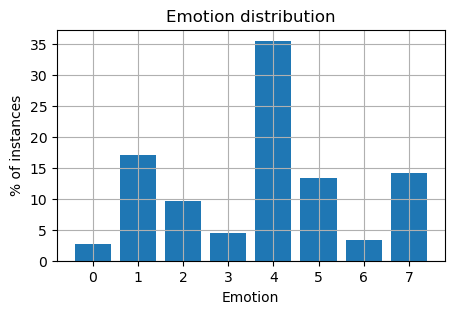

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['labels'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['labels']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

### Sampling data
#### Since I always encounter the "cannot allocate memory" error, I tried to decrease the size of the dataset. In the case of using 3 sentences per emotion, the model can be trained successfully. However, the testing set still cannot run properly. The ram of the computer is not enough.

In [16]:
# sampling data
new_df = train_df.groupby(['labels']).sample(n=4)
new_df.groupby(['labels']).count()['text']

labels
0    4
1    4
2    4
3    4
4    4
5    4
6    4
7    4
Name: text, dtype: int64

In [17]:
new_df = new_df.sample(frac=1)
new_df.head()

,text,labels
1225969,When ur doctor tells u ur slightly anemic???? ...,5
92497,@grinningduck For everyone is a #hypocrite and...,0
177331,@DairyQueenManor No! And they were <LH> ! I’m ...,4
98174,That ‘Kane’ team finished 8 points above city....,3
528409,@mushenska What's her face and the davidoff bl...,6


### Preprocessing 
#### To improve the performance of BERT, I need to get all the sentences in a consistent format. We need to clean, tokenize and convert the data by making the text lowercase, removing hyperlinks, removing punctuation, removing numbers, tokenizing, and removing stopwords.

In [18]:
# text preprocessing helper functions
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

def preprocess(t):
    t['text_clean'] = t['text'].apply(str).apply(lambda x: text_preprocessing(x))
    t.drop(['text'], axis=1, inplace=True)
    t = t.rename(columns = {"text_clean":"text"})
    return t

#### Set some hyperparameters for the model.

In [19]:
cuda_available = torch.cuda.is_available()
model_args = ClassificationArgs( 
    num_train_epochs=5, 
    learning_rate=1e-4,
    #train_batch_size=4,
    #eval_batch_size=4,
    # output_dir='output', 
    overwrite_output_dir= True,
    process_count = 20,
    use_multiprocessing = True
    )
model = ClassificationModel( "roberta", "roberta-base", use_cuda=cuda_available,num_labels=8, args=model_args )

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [20]:
train_df = preprocess(new_df)
train_df = train_df.reindex(columns=['text','labels'])
test_df = preprocess(test_df)


/tmp/ipykernel_12656/1004600832.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['text_clean'] = t['text'].apply(str).apply(lambda x: text_preprocessing(x))
/tmp/ipykernel_12656/1004600832.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.drop(['text'], axis=1, inplace=True)


In [21]:
test_df.shape

(411972, 1)

In [22]:
train_df.head()

,text,labels
1225969,when ur doctor tells u ur slightly anemic like...,5
92497,grinningduck for everyone is a hypocrite and a...,0
177331,dairyqueenmanor no and they were i m still dre...,4
98174,that kane team finished points above city also...,3
528409,mushenska whats her face and the davidoff blok...,6


### Train the model

In [25]:
model.train_model(train_df)

OSError: [Errno 12] Cannot allocate memory

Cannot allocate memory error :'(

In [ ]:
test_x = test_df['text'].values.tolist()

In [ ]:
len(test_x)

In [ ]:
pred,_=model.predict(test_x[:100])
print(pred)
#max_list = np.argmax(prediction, axis=1)
#max_list

In [ ]:
pred,_=model.predict(test_x[:1000])
print(pred)